# Accuracy Assessment of WOfS Product in Africa using Ground Truth Data  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary),
[usgs_ls8c_level2_2]()

Notes:
* Landsat 8 collection 2 is confidential at continental level on 26 June 2020.
* This notebook should be run in Collection 2 Read Private Workspace should we need to run the Landsat 8 Collection 2 Sample dataset. 

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks. 

Accuracy assessment for WOfS product in Africa includes generating a confusion error matrix for a WOFL binary classification.
The inputs for the estimating the accuracy of WOfS derived product are a binary classification WOFL layer showing water/non-water and a shapefile containing validation points collected by [Collect Earth Online](https://collect.earth/) tool. Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

## Description
This notebook explains how you can perform accuracy assessment for WOFS derived product using collected ground truth dataset. 

The notebook demonstrates how to:

1. Load collected validation points as a list of observations each has a location and month
2. Query WOFL data for the collected points and capture available WOfS observation available
3. Extract statistics for each WOfS observation in each validation point including min, max and mean values for each point (location and month)
4. Extract a LUT for each point that contains both validation info and WOfS result for each month 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

* Two extreme cases: 
    - only test wofs classifier and excluding clouds is ok 
     - keep clear observations and remove non-clear ones
     - then query on those that are water/non-water
    - include terrain so water observed and no terrain is predicted true 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [13]:
%matplotlib inline

import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from deafrica_plotting import display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard
from rasterio.mask import mask

### Connect to the datacube

In [14]:
dc = datacube.Datacube()

### Analysis parameters

In [18]:
#make sure that validation points have at least three columns : location (x,y), class, as well as 12 records for each observation  
#Path to the validation data points csv file 
CEO = '../Supplementary_data/Validation/CEO_RCMRD_2020-07-23.csv'

### Loading Dataset

In [19]:
#Read in the validation data csv
df = pd.read_csv(CEO, delimiter=",")
ground_truth = df.drop(['SAMPLE_ID','USER_ID','IMAGERY_TITLE','COLLECTION_TIME','ANALYSIS_DURATION','PL_PLOTID'], axis=1)

In [20]:
ground_truth = ground_truth.rename(columns={'WHAT IS THE FEATURE?':'CLASS','ENTER MONTHS[1-12] IN 2018, WATER WAS OBSERVED?':'WATER',
                                            'ENTER MONTHS[1-12] IN 2018, WATER WAS NOT OBSERVED?':'NO_WATER','ENTER MONTHS[1-12] IN 2018, IMAGE WAS BAD?':'BAD_IMAGE',
                                            'THAT YOU ARE UNSURE IF YOU OBSERVE WATER OR NOT? ':'NOT_SURE'})
ground_truth.head()

,PLOT_ID,LON,LAT,FLAGGED,ANALYSES,SENTINEL2MOSAICYEARMONTH,WATER,NO_WATER,BAD_IMAGE,NOT_SURE,CLASS,COMMENT
0,137361994,11.113083,36.894297,False,1,2019 - 2019,1-Dec,0,0,0,Open water - freshwater,Na
1,137361995,5.688374,36.050819,False,1,2018 - 2018,"1-6,10-12",7-Sep,0,0,Open water - freshwater,N/a
2,137361996,15.279478,32.305943,False,1,2018 - 2018,1-Dec,0,0,0,Open water - marine,N/a
3,137361997,33.691526,25.628816,False,1,2018 - 2018,0,1-Dec,0,0,Barren (Bare soil / Rocky Land),N/a
4,137361998,32.561624,25.288989,False,1,2018 - 2018,1-Dec,0,0,0,Open water - freshwater,N/a


In [6]:
#replacing the name of months with their numerical values
replacements = { 'WATER': {r'Jan':'1', r'Feb':'2',r'March':'3',r'Apr':'4',r'May':'5',r'Jun':'6',r'Jul':'7',r'Aug':'8',r'Sep':'9',r'Oct':'10',r'Nov':'11',r'Dec':'12'},
               'NO_WATER': {r'Jan':'1', r'Feb':'2',r'March':'3',r'Apr':'4',r'May':'5',r'Jun':'6',r'Jul':'7',r'Aug':'8',r'Sep':'9',r'Oct':'10',r'Nov':'11',r'Dec':'12'},
               'BAD_IMAGE':{r'Jan':'1', r'Feb':'2',r'March':'3',r'Apr':'4',r'May':'5',r'Jun':'6',r'Jul':'7',r'Aug':'8',r'Sep':'9',r'Oct':'10',r'Nov':'11',r'Dec':'12'}}

ground_truth.replace(replacements, regex=True, inplace=True)

In [7]:
#Converting all column types to string if not already 
ground_truth['NOT_SURE'] = ground_truth.NOT_SURE.astype(str)

In [8]:
def split_str(row, newtable):
#check each row for WATER info an update the water column 
    monthstr=row['WATER']
    if monthstr!='0':
        monthlist=[[int(i) for i in s.split('-')] for s in monthstr.split(',')]
        for l in monthlist:
            if len(l)==1: l=[l[0],l[0]]
            for i in range(l[0], l[1]+1):
                newrow=row[['PLOT_ID','LON','LAT','FLAGGED','ANALYSES','WATER','NO_WATER','BAD_IMAGE','NOT_SURE','CLASS','COMMENT']]
                newrow['MONTH']=f'{i:02d}'
                newrow['WATERFLAG']='1'
                newrow["SENTINEL2YEAR"]='2018'
                newtable=newtable.append(newrow)
#check each row for non-water info 
    monthstr=row['NO_WATER']
    if monthstr!='0':
        monthlist=[[int(i) for i in s.split('-')] for s in monthstr.split(',')]
        for l in monthlist:
            if len(l)==1: l=[l[0],l[0]]
            for i in range(l[0], l[1]+1):
                newrow=row[['PLOT_ID','LON','LAT','FLAGGED','ANALYSES','WATER','NO_WATER','BAD_IMAGE','NOT_SURE','CLASS','COMMENT']]
                newrow['MONTH']=f'{i:02d}'
                newrow['WATERFLAG']='0'
                newrow["SENTINEL2YEAR"]='2018'
                newtable=newtable.append(newrow)  # update index / ignore original index
#check each row for bad image 
    monthstr=row['BAD_IMAGE']
    if monthstr!='0':
        monthlist=[[int(i) for i in s.split('-')] for s in monthstr.split(',')]
        for l in monthlist:
            if len(l)==1: l=[l[0],l[0]]
            for i in range(l[0], l[1]+1):
                newrow=row[['PLOT_ID','LON','LAT','FLAGGED','ANALYSES','WATER','NO_WATER','BAD_IMAGE','NOT_SURE','CLASS','COMMENT']]
                newrow['MONTH']=f'{i:02d}'
                newrow['WATERFLAG']='2'
                newrow["SENTINEL2YEAR"]='2018'
                newtable=newtable.append(newrow) 
    monthstr=row['NOT_SURE']
    if monthstr!='0':
        monthlist=[[int(i) for i in s.split('-')] for s in monthstr.split(',')]
        for l in monthlist:
            if len(l)==1: l=[l[0],l[0]]
            for i in range(l[0], l[1]+1):
                newrow=row[['PLOT_ID','LON','LAT','FLAGGED','ANALYSES','WATER','NO_WATER','BAD_IMAGE','NOT_SURE','CLASS','COMMENT']]
                newrow['MONTH']=f'{i:02d}'
                newrow['WATERFLAG']='3'
                newrow["SENTINEL2YEAR"]='2018'
                newtable=newtable.append(newrow) 
                
    return newtable


In [9]:
#Making an empty dataframe
result = pd.DataFrame()

In [10]:
for irow in range(len(ground_truth)):
    result=split_str(ground_truth.iloc[irow], result)
    result.update(result)

In [11]:
#result
result.loc[13]#this shows all the table 

,ANALYSES,BAD_IMAGE,CLASS,COMMENT,FLAGGED,LAT,LON,MONTH,NOT_SURE,NO_WATER,PLOT_ID,SENTINEL2YEAR,WATER,WATERFLAG
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,01,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,02,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,03,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,04,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,05,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,06,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,07,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,09,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,10,12,"1-7,9-12",137362007.0,2018,0,0
13,1.0,9,Cultivated (Cropland/ Plantation),NaN,0.0,-17.207002,48.61344,11,12,"1-7,9-12",137362007.0,2018,0,0


In [12]:
#extra notes on working with Pandas 

# we need a loop that goes through the table and get the values of row one at the time
#list of column names
#column_names = [] #['PLOT_ID','LON','LAT','FLAGGED','ANALYSES','SENTINEL2YEAR','WATER','NO_WATER','BAD_IMAGE','NOT_SURE','CLASS','COMMENT']

#convert to geodataframe and drop the columns that you dont want 
# ground_truth = gpd.GeoDataFrame(
#     df.drop(['SAMPLE_ID','USER_ID','IMAGERY_TITLE','COLLECTION_TIME','ANALYSIS_DURATION','PL_PLOTID'], axis=1),
#     crs='epsg:4693')

## changing the data type of specific column 


#get the value of the cell in specific column like WATER
#ground_truth.iloc[2]['NO_WATER']
#ground_truth.dtypes

#splitting the values for mont in each category 
# ground_truth[['WA','WB']] = ground_truth.WATER.str.split(",", expand=True)
# ground_truth[['NWA','NWB']] = ground_truth.NO_WATER.str.split(",",expand=True)
# ground_truth[['BIA','BIB']] = ground_truth.BAD_IMAGE.str.split(",",expand=True)
# ground_truth.WB.fillna(value=pd.np.nan, inplace=True)

# ground_truth.WATER = ground_truth.WATER.str.split()
# ground_truth.NO_WATER = ground_truth.NO_WATER.str.split()
# ground_truth.BAD_IMAGE = ground_truth.BAD_IMAGE.str.split()
# ground_truth

#list of samples 
# sample_names = ground_truth['PLOT_ID'].to_list()
# rows = len(sample_names)

#How to observe one row 
#row = ground_truth.iloc[0]
#row 
#row["WATER"]

#etc.
#result['WATER'].values[i+1] = split_str(ground_truth.iloc[irow], newtable)
#check if this row has correct year etc
# newtable=split_str(ground_truth.iloc[irow], newtable)

# for i in ground_truth.index:
#     out=split_str(ground_truth.loc[i], newtable)
#test=newtable.append(ground_truth.iloc[irow][['PLOT_ID','LON','LAT']])

In [17]:
def cast_list(x):
    if isinstance(x, list):
        return list(map(cast_list, x))
    else:
        return int(x)

In [259]:
numRows = len(ground_truth)
Water = []
for row in range(0, numRows):
    Water.append(ground_truth.WA[row].split('-'))

In [257]:
mask = ground_truth.applymap(lambda x: x is None)
cols = ground_truth.columns[(mask).any()]
for col in ground_truth[cols]:
    ground_truth.loc[mask[col], col] = ''
ground_truth

In [280]:
Water_int = cast_list(Water)

In [236]:
# for w in range(len(Water)):
#     for v in range(len(Water[w])):
#         if Water[w][0:1] == Water[w: ][0:1]:
#             [Water[w][0], Water[w][1], sum(Water[w][v+2], Water[w: ][v+2])]

In [7]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

In [10]:
buffer = 0.2
#buffer = 15 
#setting up a query dictionay
for i in coords:
    query = {
        'x':(i[0]-buffer,i[0]+buffer),
        'y':(i[1]-buffer,i[1]+buffer),
        'time':('2018-01','2018-12'),
        'resolution':(-30,30)
    }
   # output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2',query=query) have everything in 6933 and buffer 15m
    # Load the data from the datacube
    wofls = dc.load(product = "ga_ls8c_wofs_2", output_crs = 'EPSG:6933', group_by="solar_day", fuse_func=wofs_fuser,**query).squeeze()
    # Plot the loaded WOFLs
#     wofl = wofls.isel(time=5)
#     #wofls.water.plot(col="time",col_wrap=3)
#     (wofl.water == 128).plot.imshow()
#     plt.show()

## Create a query 

In [250]:
for key, value in query.items():
    print(key[i], ' : ', value)

x  :  (25.42881575000006, 25.828815750000057)
y  :  (33.491525800000076, 33.89152580000008)
time  :  ('2018-01', '2018-12')
resolution  :  (-30, 30)


In [242]:
#In order to find the available dataset use the following command  
#dc.find_datasets(product='ga_ls8c_wofs_2', **query)
#output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2_terrain',query=query) #use the collection 2 one here that should have 2018

## Load WOFL dataset derived from Landsat-8 collection 2 provisional data
To load WOFL data, we can first create a re-usable query as above that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [118]:
# Load the data from the datacube
wofls_terrain = dc.load(product = "ga_ls8c_wofs_2_terrain", output_crs = output_crs, group_by = "solar_day",fuse_func=wofs_fuser, **query)

In [119]:
#In case of comparsion with wofls_terrain over a year 
wofls_summary = dc.load(product = "ga_ls8c_wofs_2_annual_summary", output_crs = output_crs, **query) #no need to add fuse for the annual summary part 

In [120]:
# Plot the loaded WOFLs
#wofls.water.plot(col="time",col_wrap=3)
#plt.show()

In [121]:
wofls = dc.load(product = "ga_ls8c_wofs_2", output_crs = output_crs, **query) #do a masking on wet=True

In [122]:
# Select a set of images in order to the maximum calculation 
wofl = wofls_terrain.isel(time=20)

In [123]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls_terrain)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing or saturated
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",Terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


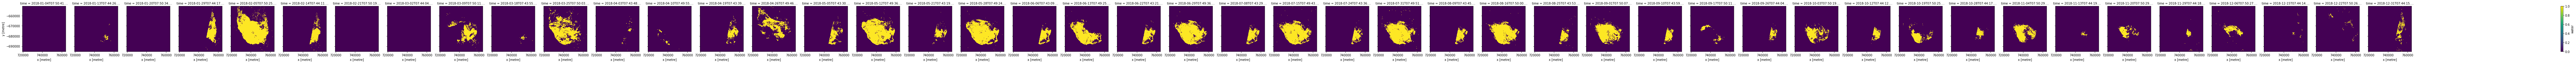

In [124]:
# Show areas flagged as water only (with no other flags set)
(wofls_terrain.water == 128).plot.imshow(col = 'time') #In case that you have time component which  comes with more than one dataset, you need to add col ='time' as an argument to the imshow() 
plt.show()

We can convert the WOFL bit field into a binary array containing True and False values. This allows us to use the WOFL data as a mask that can be applied to other datasets.
The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above. For more details on how to do masking on WOfS, see the [Applying_WOfS_bit_masking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.


In [125]:
wofl_selected = wofls
wofls_mask = {'wet':True}
wofls_output = masking.make_mask(wofl_selected, **wofls_mask)
wofls_output.water.sum(dim='time')

<xarray.DataArray 'water' (y: 1482, x: 1483)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 7.195e+05 7.195e+05 ... 7.639e+05 7.64e+05
  * y            (y) float64 -6.507e+05 -6.507e+05 ... -6.951e+05 -6.951e+05
    spatial_ref  int32 32636

In [126]:
wofl_selected = wofls_terrain #.sel(time=slice('2018-06-01', '2018-12-30'))
wet_nocloud = {"water_observed":True, "cloud_shadow":False, "cloud":False, "noncontiguous":False, "nodata":False}
wofl_wetnocloud = masking.make_mask(wofl_selected, **wet_nocloud).astype(int) #using astype(int) will convert the original bool value to integer 
wofl_wet = wofl_wetnocloud.water.sum(dim='time') 
#wofl_wetnocloud.water.max(dim='time') #if =1 means water observed but =0 means other classes that water is available 


In [127]:
dry_nocloud = {"water_observed":False, "cloud_shadow":False, "cloud":False, "noncontiguous":False, "nodata":False}
wofl_drynocloud = masking.make_mask(wofl_selected, **dry_nocloud)
wofl_dry = wofl_drynocloud.water.sum(dim='time')
 
# (dry and nocloud.water.sum(dim=time) + wet and nocloud.water.sum(dim=time)) > 0 #ther is clear observation 
# wetwofl.water.plot()
# plt.show()

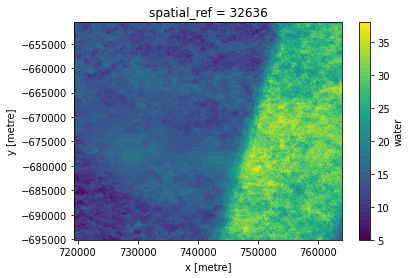

In [128]:
wofl_clear_observations = wofl_dry + wofl_wet
#wofl_clear_observations[10].plot() #this will show the graph of water observation frequency in that location as we move horizontally
wofl_clear_observations.plot() #the image itself 
plt.show()

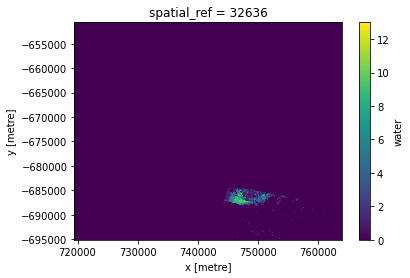

In [129]:
wofl_selected = wofls_summary
#b = wofl_selected.count_wet
c = wofls_output.sum(dim='time')

(c.water - wofl_wet).plot() #try the masking for the layer with the masking that you used for other dataset. 
#(b - wofl_clear_observations).plot(vmin=-1, vmax=1)
#(b - wofl_clear_observations).mean()
#wofl_selected.count_wet.plot()
#wofl_selected.frequency.plot()

In [130]:
# #In case you are interested to load other dataset you can use the load_ard but this command doesnt workd for services like WOfS; however, it does work for fractional cover based on collection2 dataset. 
# output_crs = mostcommon_crs(dc=dc, product='usgs_ls8c_level2_2', query=query)
# # Load available data from Landsat 8 and filter to retain only times
# # with at least 99% good data
# ds = load_ard(dc=dc,
#               products=['usgs_ls8c_level2_2'],
#               output_crs=output_crs,
#               align=(15, 15),
#               **query)

In [273]:
#rename the column class to actual 
ground_truth = ground_truth.rename(columns={'WHAT_IS_TH':'Actual'})
ground_truth.head()

,SAMPLE_ID,LON,LAT,ANALYSES,IMAGERY_TI,SENTINEL2M,PL_PLOTID,ENTER_MONT,COMMENTS,Actual,geometry
0,510677376,11.113083,36.894297,1,Sentinel 2,2018 - 2018,1,1-Dec,NA,Open water - marine,POINT (11.11308 36.89430)
1,510677377,5.688374,36.050819,1,Sentinel 2,2018 - 2018,2,"1,2,3,4,5,6","For October to December, there area was green.",Open water - freshwater,POINT (5.68837 36.05082)
2,510677378,15.279478,32.305943,1,Sentinel 2,2018 - 2018,3,1-Dec,NA,Open water - marine,POINT (15.27948 32.30594)
3,510677379,33.691526,25.628816,1,Sentinel 2,2018 - 2018,4,0,NA,Barren (Bare soil / Rocky Land),POINT (33.69153 25.62882)


In [ ]:
#Path to the validation data points shapefile 
grd_truth = '../Supplementary_data/Validation/CEOSamplePoints_Val.shp'
#pred_tif = 'path to the WOFL geotiff layer'
pred_tif = '../Supplementary_data/Validation/aaa.tif'
#Path to the AEZ region 
aez_region = '../Supplementary_data/Validation/simplified_AEZs/AEZs_ExcludeLargeWB_update.shp'
#areas = glob.glob('../../shapes/simplified_AEZs/*.shp') #using aez could be optional 

In [274]:
#An optional stage, if there is a need to read the AEZ region file and clip the validation points 
aez=gpd.read_file(aez_region).to_crs('EPSG:6933')

In [ ]:
#Reading the WOFL layer 
prediction = rasterio.open(pred_tif)

In [37]:
# clip validation points to region (optional)
ground_truth = gpd.overlay(ground_truth,aez,how='intersection')

### Extract a list of coordinate values 

In [38]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

#### Sample the WOFL layer at the ground truth coordinate

In [ ]:
# Sample the raster at every point location and store values in DataFrame
ground_truth['Prediction'] = [int(x[0]) for x in prediction.sample(coords)]
ground_truth.head()

In [ ]:
confusion_matrix = pd.crosstab(ground_truth['Actual'],
                               ground_truth['Prediction'],
                               rownames=['Actual'],
                               colnames=['Prediction'],
                               margins=True)
confusion_matrix

In [2]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

In [ ]:
#test the groundtruth with a 6933 EPSG as well (conversion) - how to reproject